In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import cv2
import os

# Cấu hình GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Đặt cấu hình để tự động sử dụng GPU (nếu có)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Giới hạn sử dụng bộ nhớ GPU (tùy chọn)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Hoặc bạn có thể giới hạn bộ nhớ cụ thể
        # tf.config.experimental.set_virtual_device_configuration(
        #     gpus[0],
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        print("GPU đã được cấu hình thành công!")
    except RuntimeError as e:
        print("Lỗi khi cấu hình GPU:", e)

# Tải mô hình trong ngữ cảnh GPU
with tf.device('/GPU:0'):
    # Tải mô hình MobileNetV3 không bao gồm lớp fully connected (FC)
    base_model = MobileNetV3Small(weights='imagenet', include_top=False)
    print(f"Mô hình đã được tải trên: {tf.config.list_logical_devices()}")

# Tạo batch từ nhiều ảnh để xử lý song song trên GPU
def process_batch(image_paths, batch_size=32):
    """Xử lý nhiều ảnh cùng lúc để tận dụng GPU tốt hơn"""
    batch_images = []
    processed_paths = []

    for path in image_paths:
        try:
            image = cv2.imread(path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                img_array = img_to_array(image)
                batch_images.append(img_array)
                processed_paths.append(path)
            else:
                print(f"Warning: Could not read image from path: {path}")
        except Exception as e:
            print(f"Error processing image {path}: {e}")

    if not batch_images:
        return {}, []

    # Chuyển đổi thành batch và tiền xử lý
    batch_array = np.array(batch_images)
    batch_array = preprocess_input(batch_array)

    # Trích xuất đặc trưng sử dụng GPU
    with tf.device('/GPU:0'):
        feature_maps = base_model.predict(batch_array, verbose=0)
        avg_pooled_features = tf.reduce_mean(feature_maps, axis=(1, 2)).numpy()

    # Tạo dictionary ánh xạ đường dẫn ảnh với đặc trưng
    features_dict = {path: feat for path, feat in zip(processed_paths, avg_pooled_features)}

    return features_dict, processed_paths

def extract_features(image_path):
    """Trích xuất đặc trưng cho một ảnh đơn lẻ"""
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image from path: {image_path}")

        image = cv2.resize(image, (224, 224))
        img_array = img_to_array(image)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Trích xuất đặc trưng sử dụng GPU
        with tf.device('/GPU:0'):
            feature_map = base_model.predict(img_array, verbose=0)
            avg_pooled_features = tf.reduce_mean(feature_map, axis=(1, 2))

        return avg_pooled_features.numpy()[0]
    except Exception as e:
        print(f"Error extracting features from {image_path}: {e}")
        return None

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU đã được cấu hình thành công!


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Mô hình đã được tải trên: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [ ]:
import os
import numpy as np
import cv2

def process_frames_from_folders(video_folder):

    video_action_avg_feature = []

    # Kiểm tra nếu là thư mục
    if os.path.isdir(video_folder):
        print("----" + video_folder)

        # Lấy tất cả file .jpg và loại bỏ phần mở rộng
        frame_files = [f for f in os.listdir(video_folder) if f.endswith('.jpg')]

        # Sắp xếp theo số trong tên file (vd: 000.jpg -> 0, 005.jpg -> 5, ...)
        sorted_frames = sorted(frame_files, key=lambda x: int(x.split('.')[0]))

        for frame_file in sorted_frames:
            frame_path = os.path.join(video_folder, frame_file)
            # Trích xuất đặc trưng action (ViT)
            action_avg_pooled_features = extract_features(frame_path)
            video_action_avg_feature.append(action_avg_pooled_features)

    return video_action_avg_feature

In [ ]:
class_name = "alert"
alert = []

for id in range(15):
    person_folder = "/content/drive/MyDrive/Drowsiness-Detection/Filtered_Frames/" + str(id + 1) + "/Body" + str(id + 1) + "/" + class_name
    video_folders = os.listdir(person_folder)
    video_folders = sorted(video_folders)

    for folder in video_folders:
      folder_path = os.path.join(person_folder, folder)
      video_feature = process_frames_from_folders(folder_path)
      alert.append(video_feature)

In [ ]:
feature = np.array(alert)
feature.shape

(199, 30, 576)

In [ ]:
# feature = np.array(alert)
np.save('/content/drive/MyDrive/Drowsiness-Detection/alert_body_feature.npy', feature)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## *Attention Layer*

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.saving import register_keras_serializable
import tensorflow.keras.backend as K

# Đăng ký lớp AttLayer với Keras để có thể tải mô hình
@register_keras_serializable()
class AttLayer(layers.Layer):
    """
    Attention layer for use with Keras
    """
    def __init__(self, attention_dim, **kwargs):
        """
        Initialize a new attention layer
        Args:
            attention_dim (int): Internal dimension of this layer
        """
        super(AttLayer, self).__init__(**kwargs)
        self.attention_dim = attention_dim

    def build(self, input_shape):
        """
        Initialize the internal matrices of the layer given input shape
        Args:
            input_shape (tuple): Shape of input layer (3D)
        """
        assert len(input_shape) == 3
        self.w = self.add_weight(shape=(input_shape[-1], self.attention_dim), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.attention_dim,), initializer='random_normal', trainable=True)
        self.u = self.add_weight(shape=(self.attention_dim, 1), initializer='random_normal', trainable=True)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        """
        Calculate the output of this layer
        Args:
            x: Input tensor
            mask (default None):

        Returns:
            output tensor
        """
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.w), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)

        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)
        # output = K.max(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

## *BiLSTM/LSTM Attention*

In [19]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, Activation, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

class LSTMAtt:
    def __init__(self, hidden_node, input_shape, output_width):
        self.model = Sequential([
            Input(shape=input_shape),
            # Bidirectional(LSTM(hidden_node, return_sequences=True)),
            LSTM(hidden_node, return_sequences=True),
            Dropout(0.3),
            AttLayer(hidden_node),
            Dropout(0.3),
            Dense(output_width),
            BatchNormalization(),
            Activation('gelu'),
            Dense(32),
            BatchNormalization(),
            Activation('gelu'),
            Dense(3, activation='softmax')
        ])

        # Adam optimizer
        # optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

        # Sử dụng AdamW optimizer
        optimizer = tf.keras.optimizers.AdamW(
        learning_rate=0.0003,
        weight_decay=0.0008)

        # Định nghĩa ExponentialDecay scheduler
        # initial_learning_rate = 0.0001
        # lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        #     initial_learning_rate,
        #     decay_steps=10,
        #     decay_rate=0.95,
        #     staircase=True)

        # # Khởi tạo AdamW optimizer với learning rate scheduler
        # optimizer = tf.keras.optimizers.AdamW(
        #     learning_rate=lr_schedule,  # Sử dụng scheduler cho LR
        #     weight_decay=0.00008
        # )


        # self.model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        self.model.compile(loss="categorical_hinge", optimizer=optimizer, metrics=['accuracy'])

    def summary(self):
        self.model.summary()

    def fit(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        # Huấn luyện mô hình
        self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    def predict(self, x):
        # Dự đoán
        return self.model.predict(x)

    # def evaluate(self, x_test, y_test):
    #     # Đánh giá mô hình trên dữ liệu kiểm tra
    #     y_pred = self.predict(x_test)

    #     # Đánh giá các chỉ số
    #     accuracy = accuracy_score(y_test, np.round(y_pred))
    #     precision = precision_score(y_test, np.round(y_pred))
    #     recall = recall_score(y_test, np.round(y_pred))
    #     f1 = f1_score(y_test, np.round(y_pred))

    #     # Ma trận nhầm lẫn
    #     conf_matrix = confusion_matrix(y_test, np.round(y_pred))

    #     return accuracy, precision, recall, f1, conf_matrix, y_pred
    def evaluate(self, x_test, y_test):
        y_pred = self.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
        recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
        f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
        conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

        return accuracy, precision, recall, f1, conf_matrix, y_pred

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        """
        Train the model with early stopping.
        Args:
            train_X (np.array): Training inputs
            train_labels (np.array): Training target labels
            val_X (np.array): Validation inputs
            val_labels (np.array): Validation target labels
            epochs (int): Number of training epochs
            batch_size (int): Training batch size
            patience (int): Number of epochs with no improvement after which training will be stopped (default is 2)
        """
        # ModelCheckpoint: lưu trọng số của mô hình tốt nhất trong quá trình huấn luyện
        checkpoint_filepath = '/content/drive/MyDrive/Drowsiness-Detection/model_1.weights.h5'
        model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=1)

        # EarlyStopping: dừng huấn luyện sớm nếu không có cải thiện
        patience = 2
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=1)

        # Khởi tạo callback ReduceLROnPlateau
        # reduce_lr = ReduceLROnPlateau(
        #     monitor='val_loss',        # Theo dõi validation loss
        #     factor=0.5,                # Giảm learning rate theo tỉ lệ 0.5
        #     patience=5,                # Số epoch không cải thiện trước khi giảm learning rate
        #     min_lr=1e-6,               # Learning rate tối thiểu
        #     verbose=1                  # Hiển thị log khi learning rate thay đổi
        # )

        # Huấn luyện mô hình
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            verbose=1,
            batch_size=batch_size,
            callbacks=[model_checkpoint]
        )
        return history


    def plot_training_history(self, history):
        """
        Plot training & validation loss and accuracy
        Args:
            history: History object returned by model.fit()
        """
        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot training & validation loss
        ax1.plot(history.history['loss'], label='Training Loss')
        ax1.plot(history.history['val_loss'], label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.grid(True)

        # Plot training & validation accuracy
        ax2.plot(history.history['accuracy'], label='Training Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='lower right')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def save(self, filepath="/content/drive/MyDrive/Drowsiness-Detection/model.keras"):
        self.model.save(filepath)

    def load(self, filepath):
        self.model = load_model(filepath, custom_objects={'AttLayer': AttLayer})

    def plot_evaluation_metrics(self, x_test, y_test, history):
        # Plot training history
        self.plot_training_history(history)

        # Predict and convert to class labels
        y_pred = self.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Alert', 'Drowsiness', 'Yawn'],
                    yticklabels=['Alert', 'Drowsiness', 'Yawn'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # ROC Curve for multiclass (one-vs-rest)
        # y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2])
        # y_pred_bin = y_pred

        # plt.figure(figsize=(8, 6))
        # for i in range(3):
        #     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        #     roc_auc = auc(fpr, tpr)
        #     plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')
        # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        # plt.xlim([0.0, 1.0])
        # plt.ylim([0.0, 1.05])
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title('ROC Curve (One-vs-Rest)')
        # plt.legend(loc="lower right")
        # plt.grid(True)
        # plt.show()

        # Evaluation metrics
        accuracy, precision, recall, f1, conf_matrix, y_pred = self.evaluate(x_test, y_test)

        print("\nEvaluation Metrics:")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1 Score: {f1:.3f}")
        print(f"Confusion Matrix:\n{conf_matrix}")

In [17]:
def load_and_combine_features():

    %cd /content/drive/MyDrive/ Drowsiness-Detection/Feature

    alert_face = np.load("alert_feature.npy", allow_pickle=True)
    alert_body = np.load("alert_body_feature.npy", allow_pickle=True)
    drowsy_face = np.load("drowsiness_feature.npy", allow_pickle=True)
    drowsy_body = np.load("drowsiness_body_feature.npy", allow_pickle=True)
    yawn_face = np.load("yawn_feature.npy", allow_pickle=True)
    yawn_body = np.load("yawn_body_feature.npy", allow_pickle=True)

    print("alert_face:", alert_face.shape)
    print("alert_body:", alert_body.shape)
    print("drowsy_face:", drowsy_face.shape)
    print("drowsy_body:", drowsy_body.shape)
    print("yawn_face:", yawn_face.shape)
    print("yawn_body:", yawn_body.shape)

    # Gộp toàn bộ đặc trưng face và body thành một tập dữ liệu (xem như các mẫu riêng biệt)
    X = np.concatenate([alert_face, alert_body,
                        drowsy_face, drowsy_body,
                        yawn_face, yawn_face,
                        yawn_body, yawn_body], axis=0)

    # Tạo nhãn tương ứng
    y = np.concatenate([
        np.zeros(len(alert_face)),  # alert_face -> lớp 0
        np.zeros(len(alert_body)),  # alert_body -> lớp 0
        np.ones(len(drowsy_face)), # drowsy_face -> lớp 1
        np.ones(len(drowsy_body)), # drowsy_body -> lớp 1
        np.full(len(yawn_face)*2, 2), # yawn_face -> lớp 2
        np.full(len(yawn_body)*2, 2)  # yawn_body -> lớp 2
    ])

    return X, y

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X, y = load_and_combine_features()
y_cat = to_categorical(y, num_classes=3)

/content/drive/.shortcut-targets-by-id/1bfx1-e0-4fS1ugnB5ZjZqewNcp-6L4Fv/ Drowsiness-Detection/Feature
alert_face: (201, 30, 576)
alert_body: (199, 30, 576)
drowsy_face: (154, 30, 576)
drowsy_body: (156, 30, 576)
yawn_face: (72, 30, 576)
yawn_body: (73, 30, 576)


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

In [20]:
input_shape = (30, 576)
model = LSTMAtt(hidden_node=128, input_shape=input_shape, output_width=64)
model.summary()

history = model.train(X_train, y_train, X_val, y_val, epochs=200, batch_size=64)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │       360,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ att_layer_3 (AttLayer)          │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,419 (1.48 MB)

 Trainable params: 388,227 (1.48 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/200
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3429 - loss: 1.1107
Epoch 1: val_loss improved from inf to 1.02024, saving model to /content/drive/MyDrive/Drowsiness-Detection/model_1.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.3421 - loss: 1.1116 - val_accuracy: 0.4000 - val_loss: 1.0202
Epoch 2/200
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3638 - loss: 1.0724
Epoch 2: val_loss improved from 1.02024 to 1.00674, saving model to /content/drive/MyDrive/Drowsiness-Detection/model_1.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3696 - loss: 1.0712 - val_accuracy: 0.4533 - val_loss: 1.0067
Epoch 3/200
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4189 - loss: 1.0512
Epoch 3: val_loss improved from 1.00674 to 1.00617, saving model to /content/drive/MyDrive/Drowsiness-Detection/model_1.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4141 - loss: 1.0541 - val_accuracy: 0.5067 - val_loss: 1.0062
Epoc

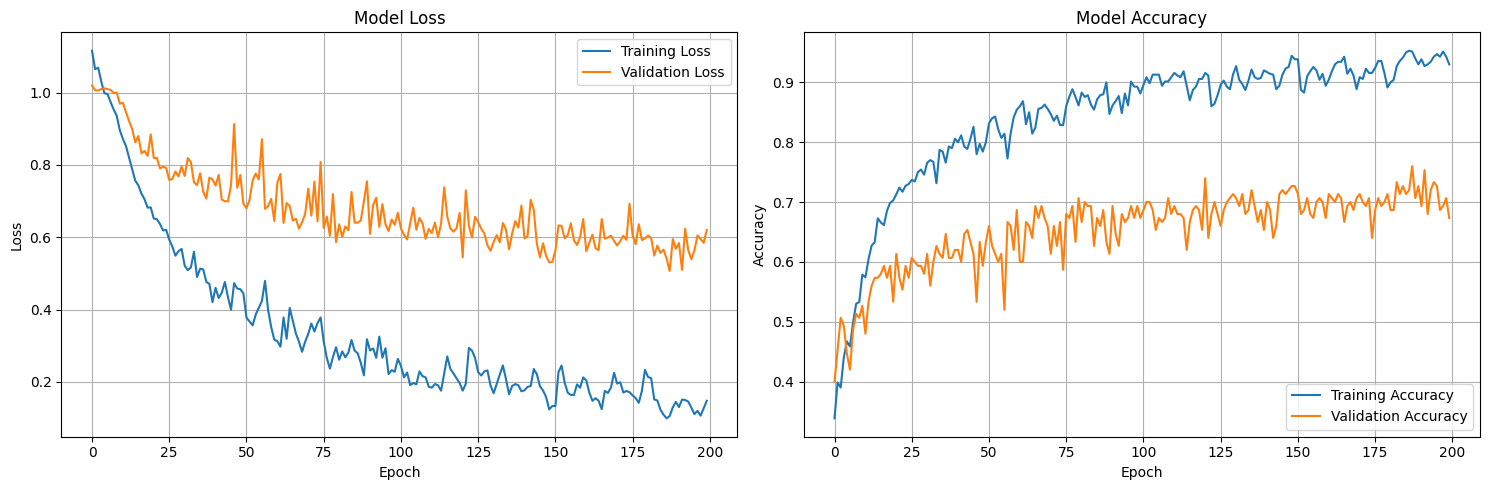

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


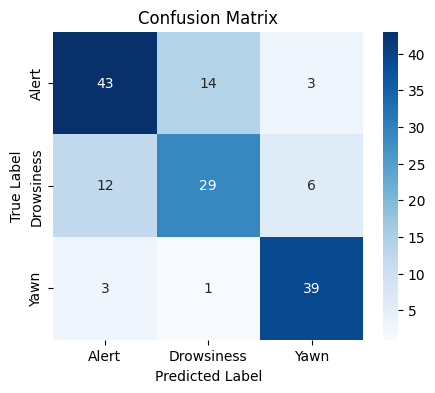

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Evaluation Metrics:
Accuracy: 0.740
Precision: 0.736
Recall: 0.740
F1 Score: 0.737
Confusion Matrix:
[[43 14  3]
 [12 29  6]
 [ 3  1 39]]


In [21]:
model.plot_evaluation_metrics(X_test, y_test, history)

In [22]:
model.save("/content/drive/MyDrive/ Drowsiness-Detection/model_lstm_attention.keras")